# Imports

In [1]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage


content_dir = './'

with open(f"{content_dir}/data/preprocessed_articles.pkl", "rb")  as input_file:
    reviewdf = pickle.load(input_file)
    
pattern = r'(enlEndNote\d+)'
reviewdf['uniqueid'] = reviewdf['record'].str.extract(pattern)
print(reviewdf['screening1'].value_counts())
print(reviewdf['screening2'].value_counts())
print(reviewdf.groupby('screening1')['screening2'].value_counts())


False    4477
True      185
Name: screening1, dtype: int64
False    4587
True       75
Name: screening2, dtype: int64
screening1  screening2
False       False         4477
True        False          110
            True            75
Name: screening2, dtype: int64


# Classification  results original criteria

In [3]:
import pickle
# Loading record2answer from its pickle file
with open(f'{content_dir}/results/record2answer_originalcrits.pkl', 'rb') as file:
    record2answer = pickle.load(file)

# Loading missing_records from its pickle file
with open(f'{content_dir}/results/missing_records_originalcrits.pkl', 'rb') as file:
    missing_records = pickle.load(file)

checkpoints_dict = {
    "Population": "f the study population comprises patients with musculoskeletal conditions, with no majority having another primary disease or intellectual disabilities, then return True. Otherwise, return False.",
    
    "Intervention":  "If physiotherapists provided one of the intervention/control group treatments alone, then return True. If the treatment of interest was offered by an interdisciplinary team, non-health care professionals, or mostly by a different profession, then return False. If the intervention combines physiotherapy with another treatment and the other treatment is provided in a comparator group, then return True. If the study evaluates the economic aspects of E-interventions, digital interventions or eHealth interventions, then return False",
  
    "Control Group": "If there is a control group of any type - for example, wait and see, usual care, placebo, or alternative treatments, then return True. Otherwise, return False.",
    
    "Outcome": "If the outcome of the study involves or allows a full economic evaluation, potentially including cost-effectiveness ratios and cost-utility ratios or if the study provides information on the costs and clinical effects of a treatment, then return True. Otherwise, return False.",
    
    "study type": "If the article is not a conference abstract, review, study without results (like a protocol), or model-based study, then return True. Otherwise, return False.",
}


print(f"CORRECTLY analyzed {len(record2answer)}")
print(f"INCORRECTLY analyzed {len(missing_records)}")

CORRECTLY analyzed 4662
INCORRECTLY analyzed 0


## Clustering analysis

In [ ]:

data_dict = {}
for key in record2answer.keys():
    data_dict[key] = {}
    for checkpoint_studied in checkpoints_dict.keys():
        data_dict[key][checkpoint_studied] = record2answer[key][checkpoint_studied]['label']


print('\n')

# Converting the dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(data_dict, orient='index')
df['screening1'] = df.index.map(dict(zip(reviewdf['uniqueid'], reviewdf['screening1'])))
df['screening2'] = df.index.map(dict(zip(reviewdf['uniqueid'], reviewdf['screening2'])))
# df['screening2'] = df.index.map(dict(zip(reviewdf['uniqueid'], reviewdf['screening2'])))
df = df.dropna()
df = df.astype(bool)
df.to_csv(f'{content_dir}/results/record2answer_originalcrits_record.csv')




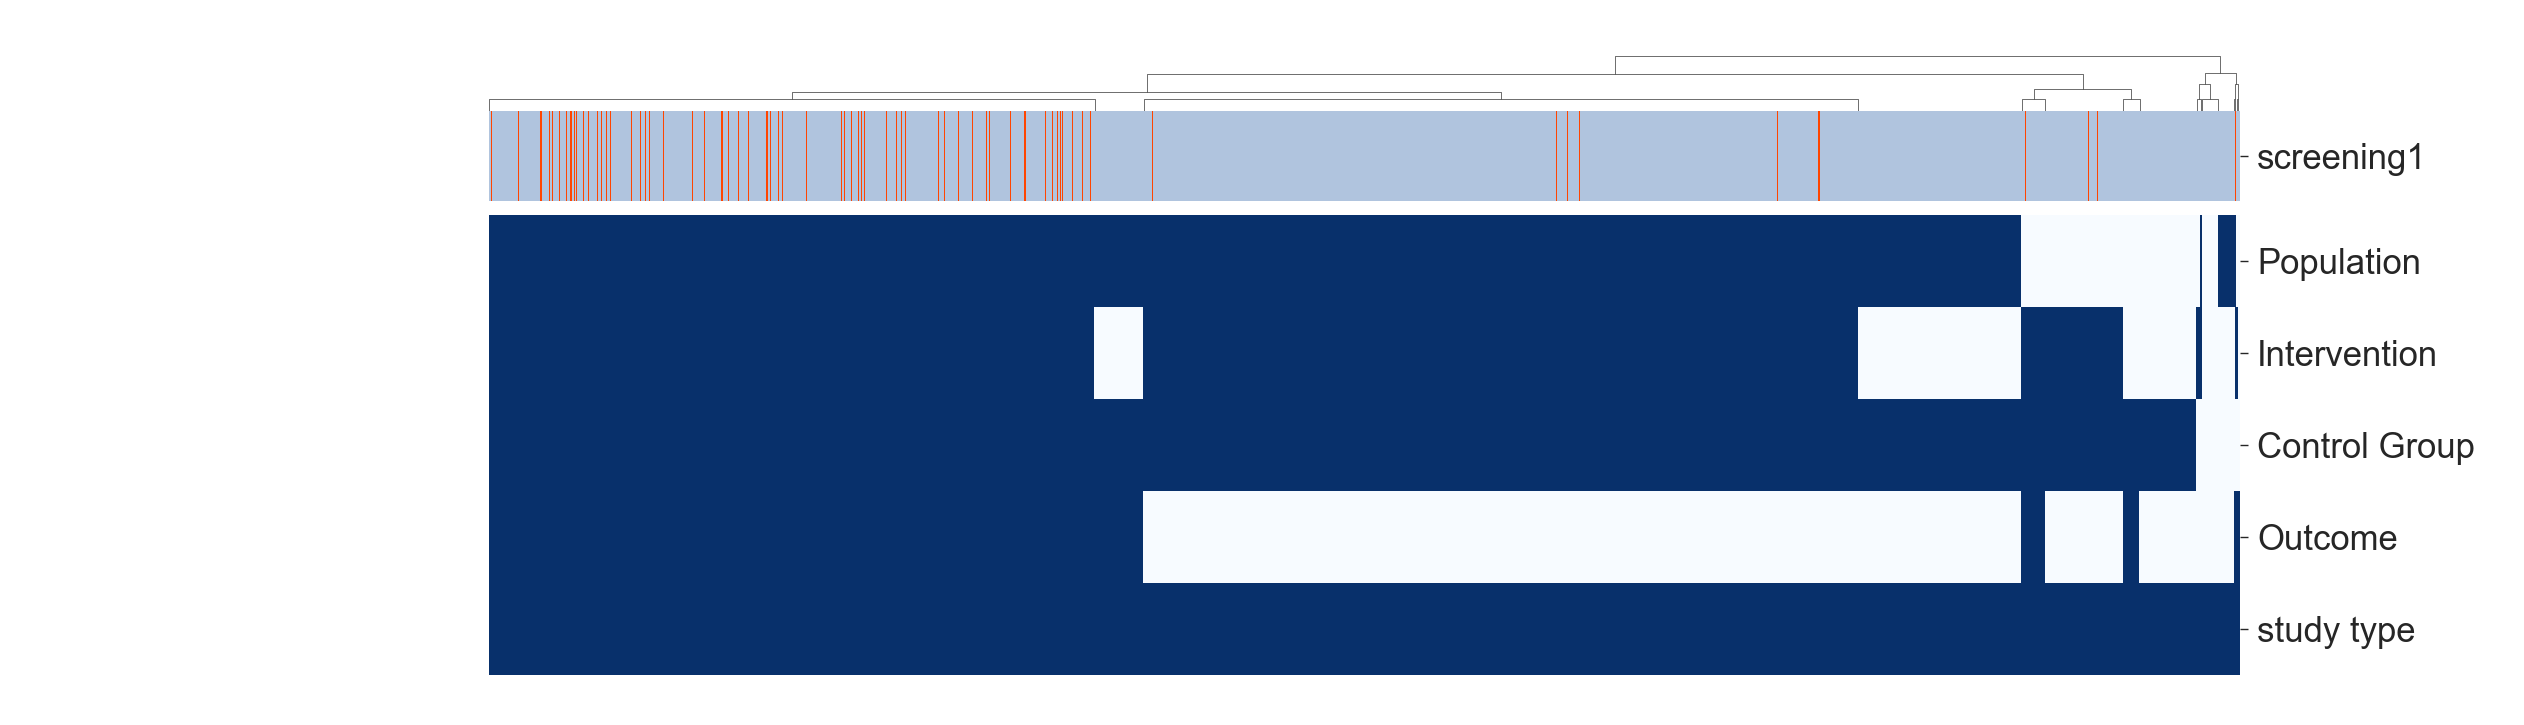

In [33]:


# Set global font size
plt.rc('font', size=25)

# Separate the data and the target column
data = df.drop(['screening1', 'screening2'], axis=1)
target = df['screening1']

# Color mapping for the columns
col_lut = {True: "orangered", False: "lightsteelblue"}
heatmap_lut =  {True: "royalblue", False: "lightsteelblue"}
col_colors = target.map(col_lut)

# Create the clustermap
g = sns.clustermap(data.T, col_colors=col_colors, method='average', cmap='Blues', xticklabels=False, figsize=(25, 7), row_cluster=False, col_cluster=True)
g.ax_heatmap.set_aspect('auto')

# Manually remove the color bar
g.cax.remove()

# Make the col_colors bar thicker
g.ax_col_colors.set_position([g.ax_col_colors.get_position().x0, g.ax_col_colors.get_position().y0,
                             g.ax_col_colors.get_position().width, g.ax_col_colors.get_position().height * 5])

# Create a legend and add it to the figure
legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in col_lut.items()]
legend_elements += [plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in heatmap_lut.items()]
# g.fig.legend(handles=legend_elements, title="Legend", bbox_to_anchor=(1.1, 1.5), loc='upper left')

# Save the figure with fixed dimensions
g.fig.set_size_inches(25, 7)
g.savefig('result_plots/clustermap_oc.png', dpi=300)

plt.show()


In [20]:
for col in df.columns:
    print(col, df[col].value_counts())

Population True     4132
False     530
Name: Population, dtype: int64
Intervention True     3806
False     856
Name: Intervention, dtype: int64
Control Group True     4545
False     117
Name: Control Group, dtype: int64
Outcome False    2797
True     1865
Name: Outcome, dtype: int64
study type True    4662
Name: study type, dtype: int64
screening1 False    4477
True      185
Name: screening1, dtype: int64
screening2 False    4587
True       75
Name: screening2, dtype: int64


## Major voting criteria


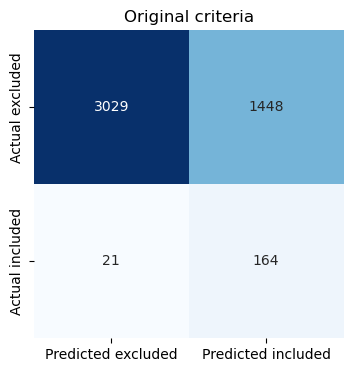

Precision: 0.102
Recall: 0.886
F1 Score: 0.183
MCC: 0.231


In [33]:
data = df.drop(['screening1', 'screening2'], axis=1)
data['All_True'] = data.all(axis=1)
target = df['screening1']

plt.rc('font', size=10)

# Generating the confusion matrix
conf_matrix_cv = confusion_matrix( df['screening1'], data['All_True'])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(conf_matrix_cv, annot=True, fmt='g', cmap='Blues', 
    xticklabels=['Predicted excluded', 'Predicted included'], 
    yticklabels=['Actual excluded', 'Actual included'], cbar=False)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
plt.title('Original criteria')
fig.savefig('result_plots/confmat_oc.png', dpi=300)
plt.show()
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, matthews_corrcoef

# Assuming 'data' and 'df' are already defined and 'data['All_True']' column exists
# Calculating the performance metrics
precision = precision_score(df['screening1'], data['All_True'])
recall = recall_score(df['screening1'], data['All_True'])
f1 = f1_score(df['screening1'], data['All_True'])
mcc = matthews_corrcoef(df['screening1'], data['All_True'])

# For AUROC and AUPR, you typically need the predicted probabilities instead of binary predictions
# If you have probability scores, you can use the following lines to calculate AUROC and AUPR
# auroc = roc_auc_score(df['screening1'], predicted_probabilities)
# aupr = average_precision_score(df['screening1'], predicted_probabilities)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"MCC: {mcc:.3f}")
# print(f"AUROC: {auroc:.3f}")
# print(f"AUPR: {aupr:.3f}")

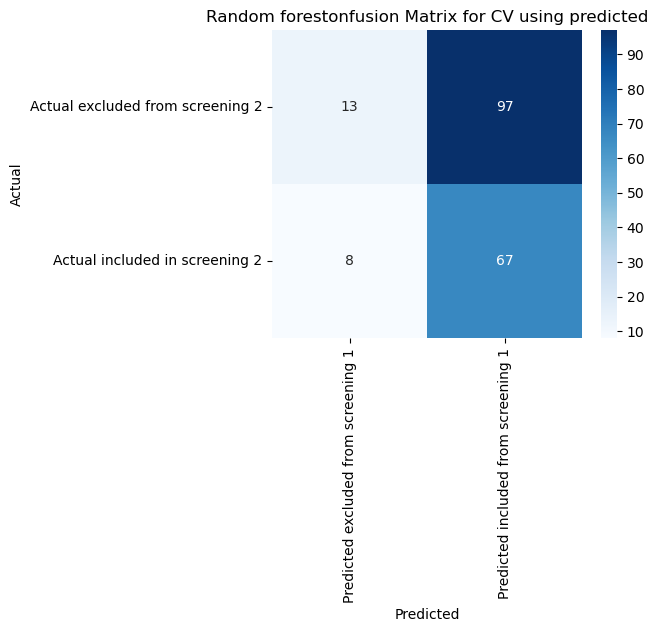

In [34]:
odds_ratio_df=pd.concat([data,  df[['screening1', 'screening2']]], axis=1)
odds_ratio_df = odds_ratio_df[odds_ratio_df.screening1 == True]

# Generating the confusion matrix
conf_matrix_OR = confusion_matrix(odds_ratio_df['screening2'], odds_ratio_df['All_True'])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(conf_matrix_OR, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted excluded from screening 1', 'Predicted included from screening 1'], 
            yticklabels=['Actual excluded from screening 2', 'Actual included in screening 2'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random forestonfusion Matrix for CV using predicted')
plt.show()

In [35]:
from scipy.stats import fisher_exact

# Construct the contingency table from the data provided
contingency_table = [
    [67, 97],  # Predicted included and their actual inclusion status
    [8, 13]    # Predicted excluded and their actual inclusion status
]

# Perform Fisher's exact test
odds_ratio, p_value = fisher_exact(contingency_table)

odds_ratio, p_value

(1.1224226804123711, 1.0)

### Random Forest
Random Forest is a versatile machine learning algorithm that operates by constructing a multitude of decision trees during training time and outputting the class that is the mode of the classes (classification) of the individual trees. It is particularly effective for datasets with a high dimensionality, offering insights into the importance of each feature in prediction. Random Forest handles the overfitting problem present with decision trees and is adept at classifying complex datasets by considering the results of numerous trees to improve the stability and accuracy of the model.

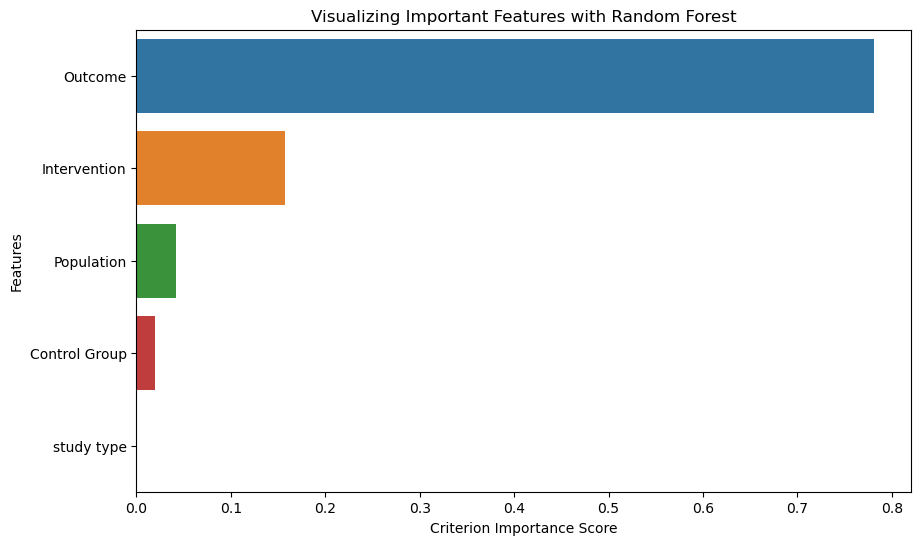

Outcome          0.781636
Intervention     0.157204
Population       0.041955
Control Group    0.019205
study type       0.000000
dtype: float64

In [38]:
from sklearn.ensemble import RandomForestClassifier

# Assuming 'screening1' is the target variable and all other columns are features
# First, we separate the features and the target variable
X = df.drop(['screening1', 'screening2'], axis=1)  # Features
y = df['screening1']  # Target variable

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_classifier.fit(X, y)

# Get the feature importances
feature_importances_og = rf_classifier.feature_importances_

# Create a pandas series to visualize the feature importances
feature_importance_series_og = pd.Series(feature_importances_og, index=X.columns)

# Sort the features by importance
sorted_feature_importances_og = feature_importance_series_og.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances_og, y=sorted_feature_importances_og.index)

# Add labels and title
plt.xlabel('Criterion Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features with Random Forest')

# Show the plot
plt.show()

# Returning the sorted feature importances for further analysis if needed
sorted_feature_importances_og


### Classification metrics 
Compute classification metrics such as precision, recall, F1 score, and accuracy to evaluate the performance of the features in classifying the target variable.
Use confusion matrices to visualize the performance of each feature as a predictor. However, we know we need to assess the different predictors together for hte classification task.

For column: Population
Precision: 0.044, Recall: 0.973, F1 Score: 0.083
For column: Intervention
Precision: 0.049, Recall: 1.000, F1 Score: 0.093
For column: Control Group
Precision: 0.040, Recall: 0.995, F1 Score: 0.078
For column: Outcome
Precision: 0.090, Recall: 0.908, F1 Score: 0.164
For column: study type
Precision: 0.040, Recall: 1.000, F1 Score: 0.076


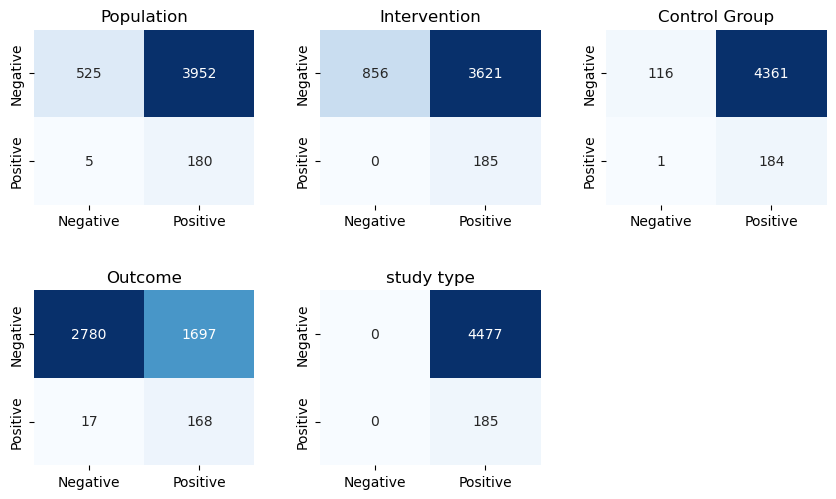

In [40]:
# Sample dataframe
# df = your_dataframe_here
data = df.drop('screening2', axis=1)  # Feature
label_col = 'screening1'
columns = [col for col in data.columns if col != label_col]

n_cols = 3  # Define number of columns for the grid
n_rows = int(len(columns) / n_cols) + (len(columns) % n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9,  8))

metrics_melted = []
for idx, column in enumerate(columns):
    row = idx // n_cols
    col = idx % n_cols

    y_true = data[label_col]
    y_pred = data[column]
    
    # Calculate and print Precision, Recall and F1 Score
    precision = precision_score(y_true, y_pred)
    metrics_melted.append([column, precision,'precision'])
    recall = recall_score(y_true, y_pred)
    metrics_melted.append([column, recall,'recall'])
    f1 = f1_score(y_true, y_pred)
    metrics_melted.append([column, f1, 'F1-score'])


    print(f"For column: {column}")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")

    # Generate the confusion matrix
    matrix = confusion_matrix(y_true, y_pred)

    # Plot the heatmap
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                ax=axes[row, col], cbar=False)
    axes[row, col].set_title(f"{column}")
    # axes[row, col].set_ylabel('Actual Label')
    # axes[row, col].set_xlabel('Predicted Label')

metrics_melted_og = pd.DataFrame(metrics_melted, columns=['Criteria', 'Value', 'Metric'])
# Remove any unused subplots
for idx in range(len(columns), n_cols * n_rows):
    fig.delaxes(axes.flatten()[idx])

# plt.tight_layout()

# Use tight_layout with padding.
fig.tight_layout(pad=3.0)
# Save the plot if needed.
plt.savefig('result_plots/confmat_og.png', dpi=300, bbox_inches='tight')

plt.show()

# Classification  results refined criteria

In [46]:
import pickle
# Loading record2answer from its pickle file
with open(f'{content_dir}/results/record2answer_refinedcrits.pkl', 'rb') as file:
    record2answer = pickle.load(file)

# Loading missing_records from its pickle file
with open(f'{content_dir}/results/missing_records_refinedcrits.pkl', 'rb') as file:
    missing_records = pickle.load(file)

checkpoints_dict = {
    "Population": "If the study population comprises patients with musculoskeletal conditions, with no majority having another primary disease or intellectual disabilities, then return True. Otherwise, return False.",

    "Intervention": "If the treatment involves physiotherapy (techniques like exercises, manual therapy, education, and modalities such as heat, cold, ultrasound, and electrical stimulation to aid in patient recovery, pain reduction, mobility enhancement, and injury prevention), or at least one of the intervention/control group treatments was provided exclusively by physiotherapists, then return True. However, if the treatment of interest was offered by an interdisciplinary team, non-health care professionals, or mostly by a different profession to physiotherapists, then return False. Otherwise, return False",

    "Phisiotherapy and another treatment": "In case at least one of the intervention/control group treatments was provided exclusively by physiotherapists, if the intervention includes physiotherapy and another treatment and the other treatment is provided in a comparator group, then return True. ",

    "E-interventions": "If the study evaluates the economic aspects of E-interventions, digital interventions or eHealth interventions, then  return False. Otherwise, return True",

    "Control Group": "If there is a control group of any type - for example, wait and see, usual care, placebo, or alternative treatments, then return True. Otherwise, return False.",

    "Outcome": "If the outcome of the study involves or allows a full economic evaluation, potentially including cost-effectiveness ratios and cost-utility ratios or if the study provides information on the costs and clinical effects of a treatment  then return True. Otherwise, return False.",

    "study type": "If the article is not a conference abstract, review, study without results (like a protocol), or model-based study, then return True. Otherwise, return False.",
}


print(f"CORRECTLY analyzed {len(record2answer)}")
print(f"INCORRECTLY analyzed {len(missing_records)}")

CORRECTLY analyzed 4662
INCORRECTLY analyzed 0


In [47]:
print(reviewdf[~reviewdf.uniqueid.isin(missing_records)]['screening1'].value_counts())
print(reviewdf[~reviewdf.uniqueid.isin(missing_records)]['screening2'].value_counts())
print(reviewdf[~reviewdf.uniqueid.isin(missing_records)].groupby('screening1')['screening2'].value_counts())

data_dict = {}
for key in record2answer.keys():
    data_dict[key] = {}
    for checkpoint_studied in checkpoints_dict.keys():
        data_dict[key][checkpoint_studied] = record2answer[key][checkpoint_studied]['label']


print('\n')

# Converting the dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(data_dict, orient='index')
df['screening1'] = df.index.map(dict(zip(reviewdf['uniqueid'], reviewdf['screening1'])))
df['screening2'] = df.index.map(dict(zip(reviewdf['uniqueid'], reviewdf['screening2'])))
# df['screening2'] = df.index.map(dict(zip(reviewdf['uniqueid'], reviewdf['screening2'])))
df = df.dropna()
df = df.astype(bool)
# df.to_csv(f'{content_dir}/screening1_info/results/record2answer_originalcrits_record.csv')

print(df['screening1'].value_counts())
print(df['screening2'].value_counts())
print(df.groupby('screening1')['screening2'].value_counts())


False    4477
True      185
Name: screening1, dtype: int64
False    4587
True       75
Name: screening2, dtype: int64
screening1  screening2
False       False         4477
True        False          110
            True            75
Name: screening2, dtype: int64


False    4477
True      185
Name: screening1, dtype: int64
False    4587
True       75
Name: screening2, dtype: int64
screening1  screening2
False       False         4477
True        False          110
            True            75
Name: screening2, dtype: int64


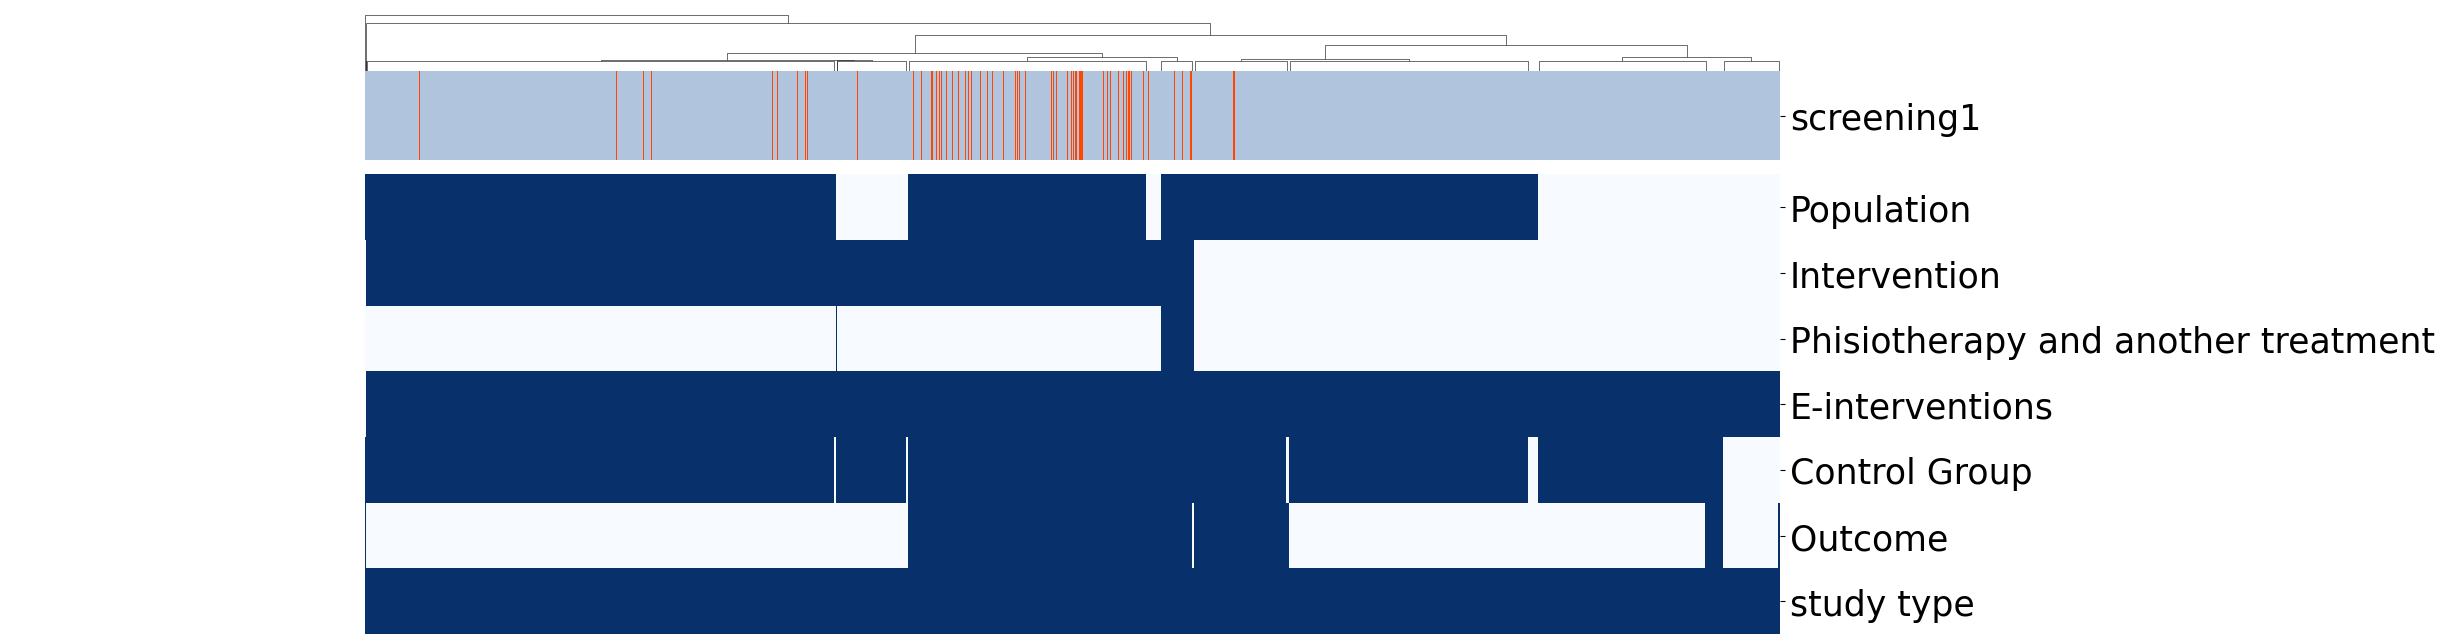

In [48]:


# Set global font size
plt.rc('font', size=25)

# Separate the data and the target column
data = df.drop(['screening1', 'screening2'], axis=1)
target = df['screening1']

# Color mapping for the columns
col_lut = {True: "orangered", False: "lightsteelblue"}
col_colors = target.map(col_lut)

# Create the clustermap
g = sns.clustermap(data.T, col_colors=col_colors, method='average', cmap='Blues', xticklabels=False, figsize=(25, 7), row_cluster=False, col_cluster=True)
g.ax_heatmap.set_aspect('auto')

# Manually remove the color bar
g.cax.remove()

# Make the col_colors bar thicker
g.ax_col_colors.set_position([g.ax_col_colors.get_position().x0, g.ax_col_colors.get_position().y0,
                             g.ax_col_colors.get_position().width, g.ax_col_colors.get_position().height * 5])

# Create a legend and add it to the figure
legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in col_lut.items()]
legend_elements += [plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in heatmap_lut.items()]
# g.fig.legend(handles=legend_elements, title="Legend", bbox_to_anchor=(1.1, 1.5), loc='upper left')

# Save the figure with fixed dimensions
g.fig.set_size_inches(25, 7)
g.savefig('result_plots/clustermap_rc.png', dpi=300, bbox_inches='tight')

plt.show()


## Major voting criteria


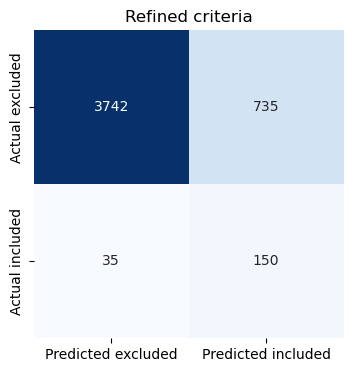

Precision: 0.169
Recall: 0.811
F1 Score: 0.280
MCC: 0.322


In [52]:
specific_sequence = [True, True, False, True, True, True, True]

# Define a modified function that ignores the third position in the sequence
def check_sequence(row, sequence):
    # Create a copy of the row with the third position replaced by the value in the sequence
    row_copy = row.values.copy()
    row_copy[2] = sequence[2]
    return (row_copy == sequence).all()
    
# Assuming 'df' is your DataFrame and it has a column 'screening1' you want to compare against.
data = df.drop(['screening1', 'screening2'], axis=1)

# Apply the function to each row to check for the sequence
data['All_True'] = data.apply(check_sequence, axis=1, sequence=specific_sequence)

target = df['screening1']

plt.rc('font', size=10)

# Generating the confusion matrix
conf_matrix_cv = confusion_matrix( df['screening1'], data['All_True'])

# Generating the confusion matrix
conf_matrix_cv = confusion_matrix( df['screening1'], data['All_True'])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(conf_matrix_cv, annot=True, fmt='g', cmap='Blues', 
    xticklabels=['Predicted excluded', 'Predicted included'], 
    yticklabels=['Actual excluded', 'Actual included'], cbar=False)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
plt.title('Refined criteria')
fig.savefig('result_plots/confmat_rc.png', dpi=300)
plt.show()
# Calculate and print Precision, Recall and F1 Score
precision = precision_score(df['screening1'], data['All_True'])
recall = recall_score(df['screening1'], data['All_True'])
f1 = f1_score(df['screening1'], data['All_True'])
mcc = matthews_corrcoef(df['screening1'], data['All_True'])

# For AUROC and AUPR, you typically need the predicted probabilities instead of binary predictions
# If you have probability scores, you can use the following lines to calculate AUROC and AUPR
# auroc = roc_auc_score(df['screening1'], predicted_probabilities)
# aupr = average_precision_score(df['screening1'], predicted_probabilities)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"MCC: {mcc:.3f}")

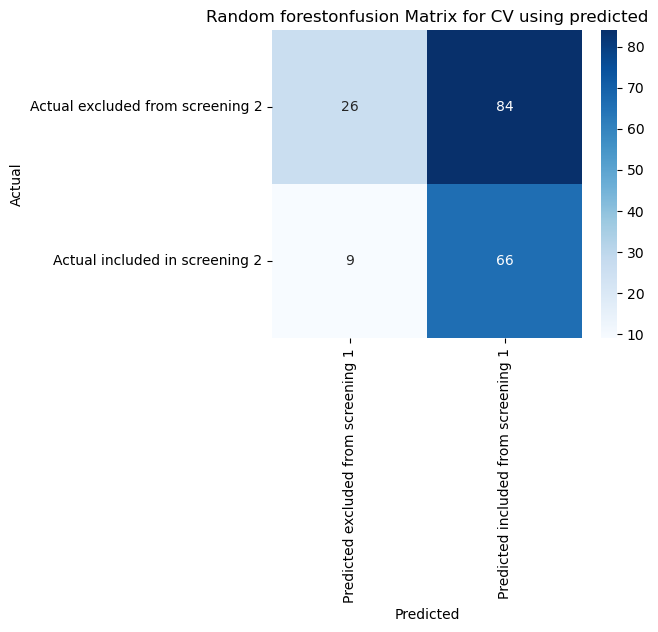

2.2698412698412698 0.0563807626568278


In [54]:
odds_ratio_df=pd.concat([data,  df[['screening1', 'screening2']]], axis=1)
odds_ratio_df = odds_ratio_df[odds_ratio_df.screening1 == True]

# Generating the confusion matrix
conf_matrix_OR = confusion_matrix(odds_ratio_df['screening2'], odds_ratio_df['All_True'])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(conf_matrix_OR, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted excluded from screening 1', 'Predicted included from screening 1'], 
            yticklabels=['Actual excluded from screening 2', 'Actual included in screening 2'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random forestonfusion Matrix for CV using predicted')
plt.show()

odds_ratio, pval = fisher_exact(conf_matrix_OR)
print(odds_ratio, pval )

In [55]:
from scipy.stats import fisher_exact

# Construct the contingency table from the data provided
contingency_table = [
    [66, 84],  # Predicted included and their actual inclusion status
    [9, 26]    # Predicted excluded and their actual inclusion status
]

# Perform Fisher's exact test
odds_ratio, p_value = fisher_exact(contingency_table)

odds_ratio, p_value

(2.2698412698412698, 0.0563807626568278)

In [56]:
OR = (66/84)/(9/26)
print(OR)

2.2698412698412698


### Random Forest
Random Forest is a versatile machine learning algorithm that operates by constructing a multitude of decision trees during training time and outputting the class that is the mode of the classes (classification) of the individual trees. It is particularly effective for datasets with a high dimensionality, offering insights into the importance of each feature in prediction. Random Forest handles the overfitting problem present with decision trees and is adept at classifying complex datasets by considering the results of numerous trees to improve the stability and accuracy of the model.

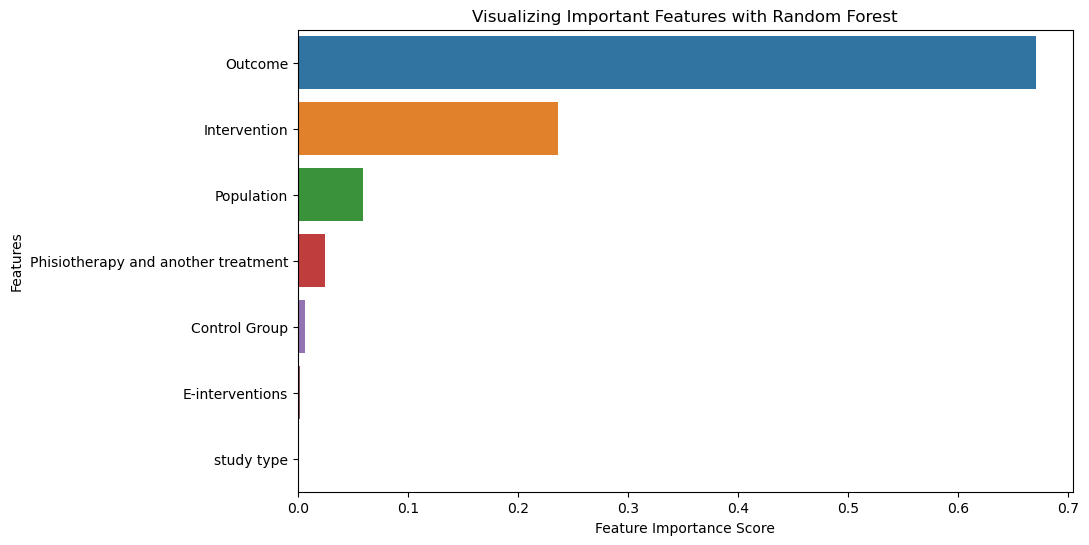

Outcome                                0.670435
Intervention                           0.236355
Population                             0.059558
Phisiotherapy and another treatment    0.025054
Control Group                          0.006428
E-interventions                        0.002169
study type                             0.000000
dtype: float64

In [71]:
from sklearn.ensemble import RandomForestClassifier

# Assuming 'screening1' is the target variable and all other columns are features
# First, we separate the features and the target variable
X = df.drop(['screening1', 'screening2'], axis=1)  # Features
y = df['screening1']  # Target variable

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_classifier.fit(X, y)

# Get the feature importances
feature_importances_rc = rf_classifier.feature_importances_

# Create a pandas series to visualize the feature importances
feature_importance_series_rc  = pd.Series(feature_importances_rc , index=X.columns)

# Sort the features by importance
sorted_feature_importances_rc  = feature_importance_series_rc.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances_rc, y=sorted_feature_importances_rc.index)

# Add labels and title
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features with Random Forest')

# Show the plot
plt.show()

# Returning the sorted feature importances for further analysis if needed
sorted_feature_importances_rc


In [74]:
fi_og_df = pd.DataFrame(sorted_feature_importances_og, columns = ['value'])
fi_og_df['criteria'] = fi_og_df.index
fi_og_df['mode'] = "original criteria"

fi_rc_df = pd.DataFrame(sorted_feature_importances_rc, columns = ['value'])
fi_rc_df['criteria'] = fi_rc_df.index
fi_rc_df['mode'] = "refined criteria"



metrics_melted_rf =pd.concat([fi_og_df,fi_rc_df])
metrics_melted_rf.to_csv("result_plots/metrics_melted_rf.csv")


### Classification metrics 
Compute classification metrics such as precision, recall, F1 score, and accuracy to evaluate the performance of the features in classifying the target variable.
Use confusion matrices to visualize the performance of each feature as a predictor. However, we know we need to assess the different predictors together for hte classification task.

For column: Population
Precision: 0.050, Recall: 0.962, F1 Score: 0.095
For column: Intervention
Precision: 0.064, Recall: 0.946, F1 Score: 0.120
For column: Phisiotherapy and another treatment
Precision: 0.081, Recall: 0.049, F1 Score: 0.061
For column: E-interventions
Precision: 0.040, Recall: 1.000, F1 Score: 0.076
For column: Control Group
Precision: 0.042, Recall: 1.000, F1 Score: 0.081
For column: Outcome
Precision: 0.121, Recall: 0.865, F1 Score: 0.213
For column: study type
Precision: 0.040, Recall: 1.000, F1 Score: 0.076


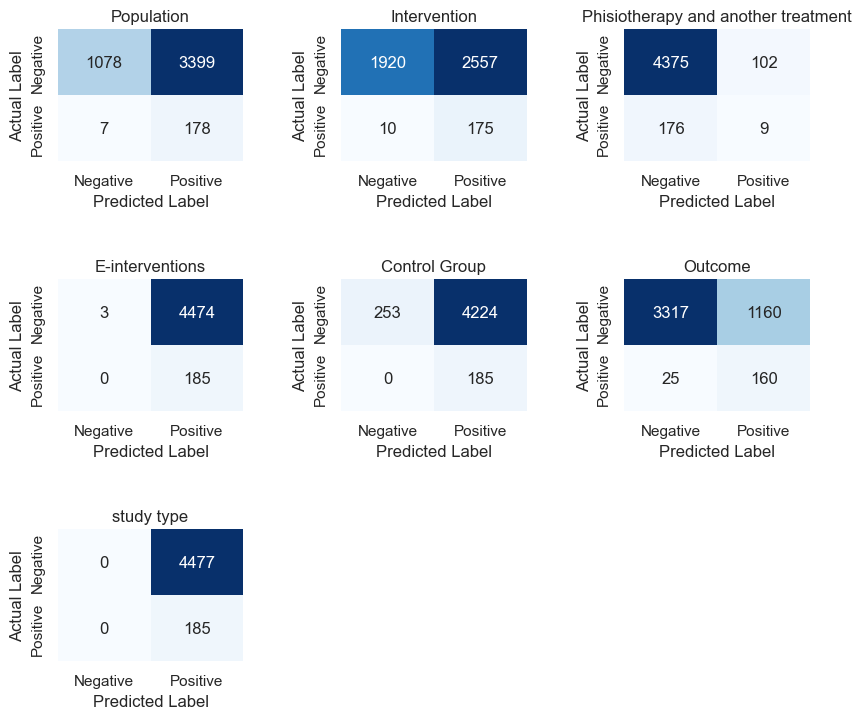

In [444]:
# Sample dataframe
# df = your_dataframe_here
data = df.drop('screening2', axis=1)  # Feature
label_col = 'screening1'
columns = [col for col in data.columns if col != label_col]

n_cols = 3  # Define number of columns for the grid
n_rows = int(len(columns) / n_cols) + (len(columns) % n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9,  8))

metrics_melted = []
for idx, column in enumerate(columns):
    row = idx // n_cols
    col = idx % n_cols

    y_true = data[label_col]
    y_pred = data[column]
    
    # Calculate and print Precision, Recall and F1 Score
    precision = precision_score(y_true, y_pred)
    metrics_melted.append([column, precision,'precision'])
    recall = recall_score(y_true, y_pred)
    metrics_melted.append([column, recall,'recall'])
    f1 = f1_score(y_true, y_pred)
    metrics_melted.append([column, f1, 'F1-score'])


    print(f"For column: {column}")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")

    # Generate the confusion matrix
    matrix = confusion_matrix(y_true, y_pred)

    # Plot the heatmap
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                ax=axes[row, col], cbar=False)
    axes[row, col].set_title(f"{column}")
    axes[row, col].set_ylabel('Actual Label')
    axes[row, col].set_xlabel('Predicted Label')

metrics_melted_rc = pd.DataFrame(metrics_melted, columns=['Criteria', 'Value', 'Metric'])
# Remove any unused subplots
for idx in range(len(columns), n_cols * n_rows):
    fig.delaxes(axes.flatten()[idx])

# plt.tight_layout()

# Use tight_layout with padding.
fig.tight_layout(pad=3.0)

# # For the metrics bar plot.
# plt.figure(figsize=(12, 6))
# # Assuming `metrics_df` is your DataFrame with 'Criteria', 'Precision', 'Recall', and 'F1 Score' columns.
# sns.barplot(x='Criteria', y='Value', hue='Metric', data=metrics_melted_rc)
# plt.title('Metric Comparison Across Criteria')
# plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.xticks(rotation=45)  # Rotate x labels if they overlap.
# plt.tight_layout()

# # Save the plot if needed.
# # plt.savefig('metrics_comparison_rc.png', dpi=300, bbox_inches='tight')
plt.savefig('result_plots/confmat_rc.png', dpi=300, bbox_inches='tight')

plt.show()